Hand Sign Detection using CNN
================

Hand Signs corresponding to digits 0 to 5 are detected using CNN . The programs are being written in Tensorflow.

The basic objective of this project is to train our computers to understand sign languages. The images contain 5 different types of signs from 0 to 5 using hand gestures. The images below represent better understanding of the sign languages that are to be detected by the computer by training using CNN

The image is shown below for better understanding.

![Hand Sign Detection](signs.png "Hand Sign Detection using CNN")

Each images are of 64 by 64 pixels and in RGB format. The training set consists of 1080 images while the testing set consist of 120 images.



We will start by loading the important packages of python and also by loading the dataset.



In [2]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow.python.framework import ops

%matplotlib inline


We will define a function called load_dataset to laod the data and save it in X_train, X_test , y_train and y_test

In [4]:
def load_dataset():
    train_dataset = h5py.File('train_signs.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('test_signs.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

# Loading the data (signs)
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

Lets see if the dataset is loaded properly. The next cell will show us an example of a labelled image in the dataset. The index values can be changed to see the different examples in the dataset

y = 2


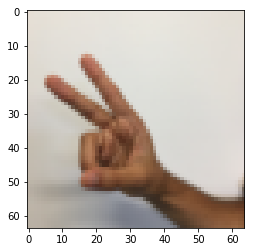

In [5]:
# Example of a picture
index = 6
plt.imshow(X_train_orig[index])
print ("y = " + str(np.squeeze(Y_train_orig[:, index])))

Since this is an image dataset, it is more natural to apply a ConvNet to it.

To get started, let's examine the shapes of our data.

We have to define a function 'convert_to_one_hot' in order to convert the labels into one hot encoded values.


In [7]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

X_train = X_train_orig/255.
X_test = X_test_orig/255.
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))
conv_layers = {}

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


CREATING PLACEHOLDERS
============

TensorFlow requires that we create placeholders for the input data that will be fed into the model when running the session.

We have to implement the function below to create placeholders for the input image X and the output Y. 

We should not define the number of training examples for the moment. To do so, we could use "None" as the batch size, it will give us the flexibility to choose it later. 

Hence X should be of dimension [None, n_H0, n_W0, n_C0] and Y should be of dimension [None, n_y].

In [8]:
def create_placeholders(n_H0, n_W0, n_C0, n_y):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_H0 -- scalar, height of an input image
    n_W0 -- scalar, width of an input image
    n_C0 -- scalar, number of channels of the input
    n_y -- scalar, number of classes
        
    Returns:
    X -- placeholder for the data input, of shape [None, n_H0, n_W0, n_C0] and dtype "float"
    Y -- placeholder for the input labels, of shape [None, n_y] and dtype "float"
    """

    
    X = tf.placeholder(tf.float32, shape=(None,n_H0,n_W0,n_C0))
    Y = tf.placeholder(tf.float32, shape=(None,n_y))
    
    return X, Y

INITIALISING PARAMETERS
=============

We will initialize weights/filters $W1$ and $W2$ using tf.contrib.layers.xavier_initializer(seed = 0). 

We don't need to worry about bias variables as you will soon see that TensorFlow functions take care of the bias. 

Please note also that we will only initialize the weights/filters for the conv2d functions. TensorFlow initializes the layers for the fully connected part automatically

In [9]:


def initialize_parameters():
    """
    Initializes weight parameters to build a neural network with tensorflow. The shapes are:
                        W1 : [4, 4, 3, 8]
                        W2 : [2, 2, 8, 16]
    Returns:
    parameters -- a dictionary of tensors containing W1, W2
    """
        
  
    W1 = tf.get_variable("W1", [4,4,3,8], initializer = tf.contrib.layers.xavier_initializer(seed=0))
    W2 = tf.get_variable("W2", [2,2,8,16], initializer = tf.contrib.layers.xavier_initializer(seed=0))

    parameters = {"W1": W1,
                  "W2": W2}
    
    return parameters


DEFINING THE CNN ARCHITECTURE
================

In TensorFlow, there are built-in functions that carry out the convolution steps for us.

1. tf.nn.conv2d(X,W1, strides = [1,s,s,1], padding = 'SAME'): given an input $X$ and a group of filters $W1$, this function convolves $W1$'s filters on X. The third input ([1,s,s,1]) represents the strides for each dimension of the input (m, n_H_prev, n_W_prev, n_C_prev).

2. tf.nn.max_pool(A, ksize = [1,f,f,1], strides = [1,s,s,1], padding = 'SAME'): given an input A, this function uses a window of size (f, f) and strides of size (s, s) to carry out max pooling over each window. 

3. tf.nn.relu(Z1): computes the elementwise ReLU of Z1 (which can be any shape).

4. tf.contrib.layers.flatten(P): given an input P, this function flattens each example into a 1D vector it while maintaining the batch-size. It returns a flattened tensor with shape [batch_size, k]. 

5. tf.contrib.layers.fully_connected(F, num_outputs): given a the flattened input F, it returns the output computed using a fully connected layer.

In the last function above (tf.contrib.layers.fully_connected), the fully connected layer automatically initializes weights in the graph and keeps on training them as we train the model. Hence, we did not need to initialize those weights when initializing the parameters.

The forward_propagation function below to build the following model: CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED

In [10]:
def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "W2"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    W2 = parameters['W2']
    
    # CONV2D: stride of 1, padding 'SAME'
    s = 1
    Z1 = tf.nn.conv2d(X,W1, strides = [1,s,s,1], padding = 'SAME')
    
    # RELU
    A1 = tf.nn.relu(Z1)

    # MAXPOOL: window 8x8, stride 8, padding 'SAME'
    f = 8
    s = 8
    P1 = tf.nn.max_pool(A1, ksize = [1,f,f,1], strides = [1,s,s,1], padding = 'SAME')

    # CONV2D: filters W2, stride 1, padding 'SAME'
    s = 1
    Z2 = tf.nn.conv2d(P1,W2, strides = [1,s,s,1], padding = 'SAME')
 
    # RELU
    A2 = tf.nn.relu(Z2)

    # MAXPOOL: window 4x4, stride 4, padding 'SAME'
    f = 4
    s = 4
    P2 = tf.nn.max_pool(A2, ksize = [1,f,f,1], strides = [1,s,s,1], padding = 'SAME')

    # FLATTEN
    P2 = tf.contrib.layers.flatten(P2)

    # FULLY-CONNECTED without non-linear activation function (not not call softmax).
    # 6 neurons in output layer.  
    Z3 = tf.contrib.layers.fully_connected(P2, 6, activation_fn=None)

    return Z3

COMPUTE COST
============

We will implement the compute cost function below. 

1. tf.nn.softmax_cross_entropy_with_logits(logits = Z3, labels = Y): computes the softmax entropy loss. This function both computes the softmax activation function as well as the resulting loss.

2. tf.reduce_mean: computes the mean of elements across dimensions of a tensor. We will use this to sum the losses over all the examples to get the overall cost.


In [11]:
def compute_cost(Z3, Y):
    """
    Computes the cost
    
    Arguments:
    Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (6, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Z3, labels = Y))
    
    return cost

BUILDING UP A MODEL
===========


Finally we will merge the helper functions we implemented above to build a model. We will train it on the SIGNS dataset.

We have to define a function named 'random_mini_batches()' which will return a list of mini-batches.


The model below should:

1. create placeholders
2. initialize parameters
3. forward propagate
4. compute the cost
5. create an optimizer

Lets first define the function 'random_mini_batches'

In [16]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples) (m, Hi, Wi, Ci)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples) (m, n_y)
    mini_batch_size - size of the mini-batches, integer
    seed -- this is only for the purpose of grading, so that you're "random minibatches are the same as ours.
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    m = X.shape[0]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation,:,:,:]
    shuffled_Y = Y[permutation,:]

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:,:,:]
        mini_batch_Y = shuffled_Y[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size : m,:,:,:]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size : m,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

We will create a session and run a for loop for num_epochs, get the mini-batches, and then for each mini-batch we will optimize the function

In [17]:
# GRADED FUNCTION: model

def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.009,
          num_epochs = 100, minibatch_size = 64, print_cost = True):
    """
    Implements a three-layer ConvNet in Tensorflow:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    Arguments:
    X_train -- training set, of shape (None, 64, 64, 3)
    Y_train -- test set, of shape (None, n_y = 6)
    X_test -- training set, of shape (None, 64, 64, 3)
    Y_test -- test set, of shape (None, n_y = 6)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    train_accuracy -- real number, accuracy on the train set (X_train)
    test_accuracy -- real number, testing accuracy on the test set (X_test)
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    seed = 3
    (m, n_H0, n_W0, n_C0) = X_train.shape             
    n_y = Y_train.shape[1]                            
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of the correct shape

    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)


    # Initialize parameters
    parameters = initialize_parameters()

    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    Z3 = forward_propagation(X, parameters)
    
    # Cost function: Add cost function to tensorflow graph
 
    cost = compute_cost(Z3, Y)

    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer that minimizes the cost.

    optimizer =  tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(loss=cost)

    
    # Initialize all the variables globally
    init = tf.global_variables_initializer()
     
    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            minibatch_cost = 0.
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                # Run the session to execute the optimizer and the cost, the feedict should contain a minibatch for (X,Y).
                _ , temp_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                
                minibatch_cost += temp_cost / num_minibatches
                

            # Print the cost every epoch
            if print_cost == True and epoch % 5 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
        
        
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # Calculate the correct predictions
        predict_op = tf.argmax(Z3, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print(accuracy)
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)
                
        return train_accuracy, test_accuracy, parameters


We will run the following cell to train your model for 100 epochs. 


Cost after epoch 0: 1.926529
Cost after epoch 5: 1.698381
Cost after epoch 10: 1.152707
Cost after epoch 15: 0.955934
Cost after epoch 20: 0.735970
Cost after epoch 25: 0.661564
Cost after epoch 30: 0.562532
Cost after epoch 35: 0.559948
Cost after epoch 40: 0.502119
Cost after epoch 45: 0.488039
Cost after epoch 50: 0.399827
Cost after epoch 55: 0.428005
Cost after epoch 60: 0.362912
Cost after epoch 65: 0.385545
Cost after epoch 70: 0.323000
Cost after epoch 75: 0.353474
Cost after epoch 80: 0.282894
Cost after epoch 85: 0.307836
Cost after epoch 90: 0.291866
Cost after epoch 95: 0.250379


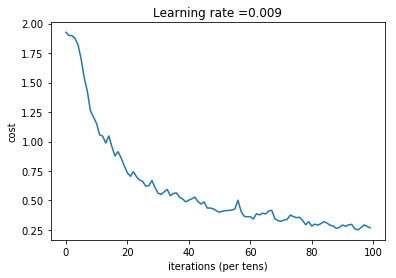

Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 0.916667
Test Accuracy: 0.816667


In [18]:
TrainAcc, TestAcc , parameters = model(X_train, Y_train, X_test, Y_test)

The train accuracy and test accuracy actually represents the case of overfitting . This can be overcomed if we use L1 or L2  regularization.